In [174]:
import pylab as plt
import pandas as pd
import numpy as np

Player data here:

https://docs.google.com/spreadsheets/d/1oaO1E-QgHjw3qLCJBU71bgQKsReGJhHHttt-zQY8kLs/edit#gid=491689579

Upload results to csv here:

https://docs.google.com/spreadsheets/d/1JLXogbowRiISc4WN4YvnH_H5Eot3-vDpDaq5KJF71D8/edit#gid=0

In [211]:
d=pd.read_csv('baller_stats.csv')
d.set_index('ID',inplace=True)

In [155]:
# Body (8250 total)
body_count =  d.groupby('Body').size()
body_frequency = body_count / body_count.sum()

# Hair (8250 total)
hair_count = d.groupby('Hair').size()
hair_frequency =  hair_count / hair_count.sum()

# Accessories (10635 total)
def strip_ln(x):
    
    try:
        return x.strip()
    except AttributeError:
        return None
        
acc_count=d['Accessories'].str.split(',', expand=True).apply(lambda x: [strip_ln(e) for e in x]).stack().value_counts().sort_values(ascending=True)
acc_frequency=acc_count/acc_count.sum()

Text(0, 0.5, 'Count')

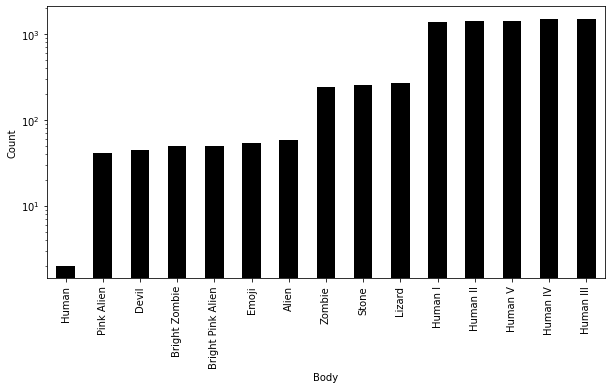

In [213]:
body_count.sort_values(ascending=True).plot.bar(logy=True,color='k',figsize=(10,5))
plt.xlabel('Body')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

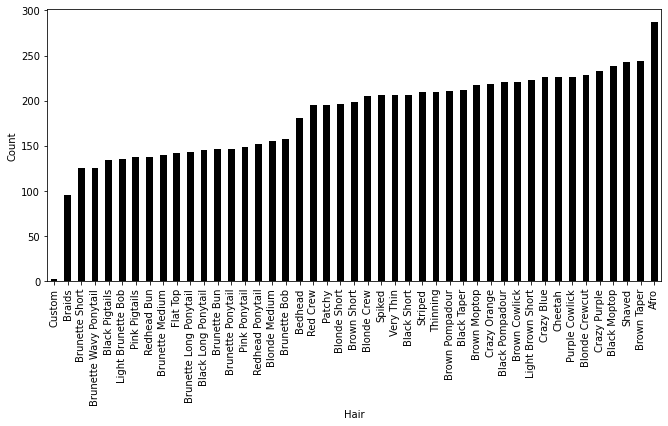

In [212]:
hair_count.sort_values().plot.bar(color='k',figsize=(11,5))
plt.ylabel('Count')

Text(0, 0.5, 'Count')

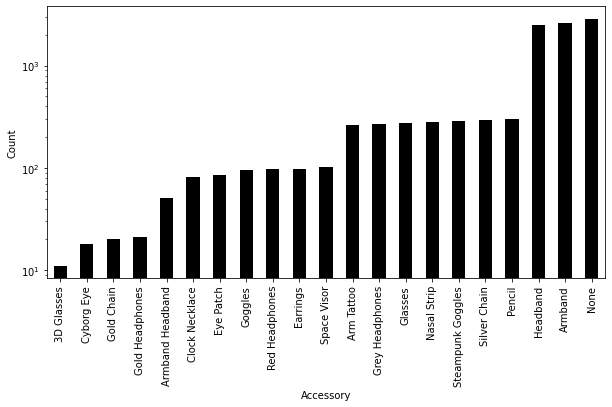

In [214]:
acc_count.sort_values(ascending=True).plot.bar(logy=True,color='k',figsize=(10,5))
plt.xlabel('Accessory')
plt.ylabel('Count')

In [184]:
# Accesory data 
acc_data=pd.DataFrame(d['Accessories'].str.split(',', expand=True).apply(lambda x: [strip_ln(e) for e in x]))
acc_data.columns=['Acc1','Acc2','Acc3']
acc_data[['Acc2','Acc3']]=acc_data[['Acc2','Acc3']].fillna(0)

# Accesory frequency
def acc_freq(x):
    try:
        return acc_frequency.loc[x]
    except:
        return 0
    
acc_data['Acc1_freq']=acc_data['Acc1'].apply(lambda x: acc_freq(x))
acc_data['Acc2_freq']=acc_data['Acc2'].apply(lambda x: acc_freq(x))
acc_data['Acc3_freq']=acc_data['Acc3'].apply(lambda x: acc_freq(x))

# Multiple acros accessories
def mult_freq(a,b,c):
    arr=np.array([a,b,c])
    arr=arr[arr>0]
    return np.prod(arr)
    
acc_data['Acc_frequency']=acc_data.apply(lambda row: mult_freq(row['Acc1_freq'],
                                                          row['Acc2_freq'],
                                                          row['Acc3_freq']),axis=1)

In [187]:
# Join
d_join=d[['Body','Team','Jersey','Hair','Role','Number','Dunks','Shooting','Overall','Playmaking','Defense','Title']]
all_f=pd.concat([acc_data,d_join],axis=1)

In [190]:
# Comppute hair, body frequency
def hair_freq(x):

    return hair_frequency.loc[x]

    
def body_freq(x):

    return body_frequency.loc[x]

all_f['Body_frequency']=all_f['Body'].apply(lambda x: body_freq(x))
all_f['Hair_frequency']=all_f['Hair'].apply(lambda x: hair_freq(x))

In [195]:
# Finalize data
l=['Body','Body_frequency','Hair','Hair_frequency','Acc1','Acc1_freq','Acc2','Acc2_freq','Acc3','Acc3_freq','Acc_frequency']
all_f_trim=all_f[l].copy()
all_f_trim['Overall_rarity']=all_f_trim['Body_frequency']*all_f_trim['Hair_frequency']*all_f_trim['Acc_frequency']
all_f_trim.replace(0, '', inplace=True)
all_f_trim.sort_values('Overall_rarity',ascending=True,inplace=True)
all_f_trim.to_csv('BALLERZ_rank.csv')

In [215]:
all_f_trim.head(3)

,Body,Body_frequency,Hair,Hair_frequency,Acc1,Acc1_freq,Acc2,Acc2_freq,Acc3,Acc3_freq,Acc_frequency,Overall_rarity
ID,,,,,,,,,,,,
7353,Human,0.000242,Custom,0.000242,None,0.270804,,,,,0.270804,1.591502e-08
5316,Human,0.000242,Custom,0.000242,None,0.270804,,,,,0.270804,1.591502e-08
4328,Bright Zombie,0.005939,Brunette Wavy Ponytail,0.015152,Armband,0.243818,Headband,0.236389,Goggles,0.009027,0.000520,4.681928e-08
